# Ejercicio de Arbol de Decisión
Realizaremos un ejercicio de prueba para comprender como funciona este algoritmo

Los arboles de decisión son representaciones gráficas de posibles soluciones a una decisión basadas en ciertas condiciones, es uno de los algoritmos de aprendizaje supervisado más utilizados en machine learning y pueden realizar tareas de clasificación o regresión (acrónimo del inglés CART). La comprensión de su funcionamiento suele ser simple y a la vez muy potente.

# Objetivo
__En este notebook intentaremos predecir quien llegará al número uno en Billboard 100 (gran lista de éxitos musicales de los 100 singles más vendidos en Estados Unidos)__

## Imports

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

## Cargamos los datos de entrada

In [2]:
artists_billboard = pd.read_csv(r"artists_billboard_fix3.csv")

In [3]:
artists_billboard.shape

(635, 11)

Esto nos devuelve (635,11) es decir que tenemos 11 columnas (features) y 635 filas de datos. Vamos a echar un ojo a los primeros registros para tener una mejor idea del contenido:

In [4]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


Vemos que tenemos: Titulo de la canción, artista, “mood” ó estado de ánimo de esa canción, tempo, género, Tipo de artista, fecha en que apareció en el billboard (por ejemplo 20140628 equivale al 28 de junio de 2014), la columna TOP será nuestra etiqueta, en la que aparece 1 si llegó al número uno de Billboard ó 0 si no lo alcanzó y el anio de Nacimiento del artista. Vemos que muchas de las columnas contienen información categórica. La columna durationSeg contiene la duración en segundos de la canción, siendo un valor continuo pero que nos convendrá pasar a categórico más adelante.

Vamos a realizar algunas visualizaciones para comprender mejor nuestros datos.

## Agrupemos registros para saber ... ¿Cuántos alcanzaron el número 1?

In [5]:
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

Es decir que tenemos 494 canciones que no alcanzaron la cima y a 141 que alcanzaron el número uno. Esto quiere decir que tenemos una cantidad DESBALANCEADA de etiquetas con 1 y 0. Lo tendremos en cuenta al momento de crear el árbol.

Visualizamos esta diferencia:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


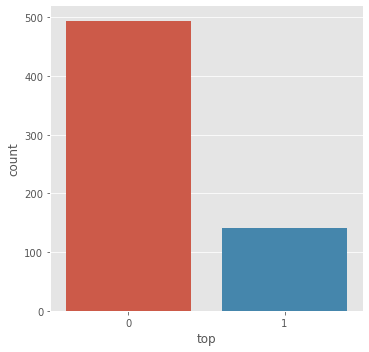

In [6]:
sb.factorplot('top',data=artists_billboard,kind="count")

Nuestras etiquetas que indican 0-No llego al Top y 1-Llego al número uno Billboard están desbalanceadas. Deberemos resolver este inconveniente

## Visualicemos los Atributos de entrada

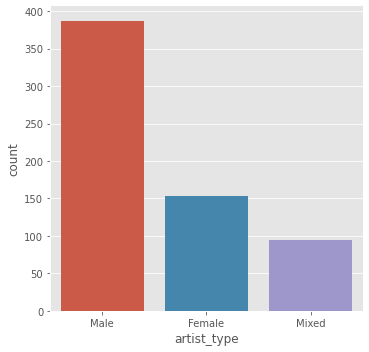

In [7]:
sb.factorplot('artist_type',data=artists_billboard,kind="count")

Aqui vemos que tenemos más del doble de artistas masculinos que femeninos y unos 100 registros de canciones mixtas

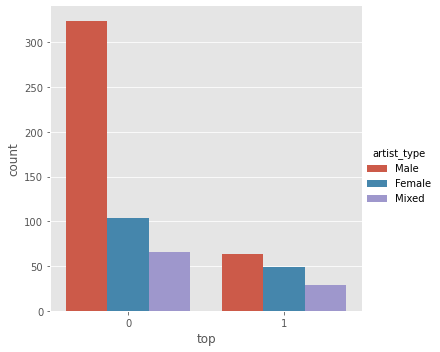

In [8]:
sb.factorplot('top',data=artists_billboard,hue='artist_type',kind="count")

Vemos por tipo de artista los que llegaron y los que no llegaron al número 1

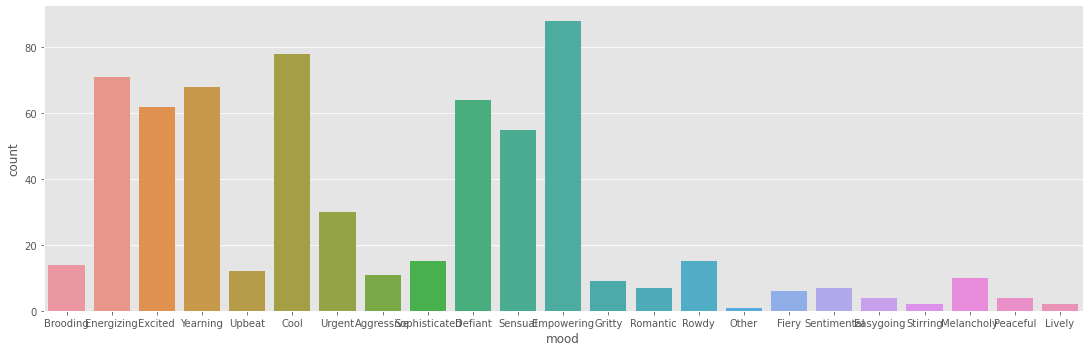

In [9]:
sb.factorplot('mood',data=artists_billboard,kind="count", aspect=3)

Vemos que de 23 tipos de Mood, destacan 7 con picos altos. Además notamos que algunos estados de ánimo son similares

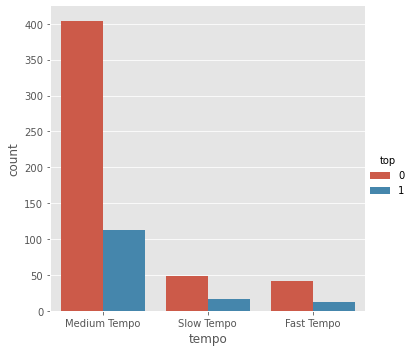

In [10]:
sb.factorplot('tempo',data=artists_billboard,hue='top',kind="count")

En esta gráfica vemos que hay 3 tipos de Tempo: Medium, Slow y Fast. Evidentemente predominan los tiempos Medium y también es donde encontramos más canciones que hayan alcanzado el Top 1 (en azul)

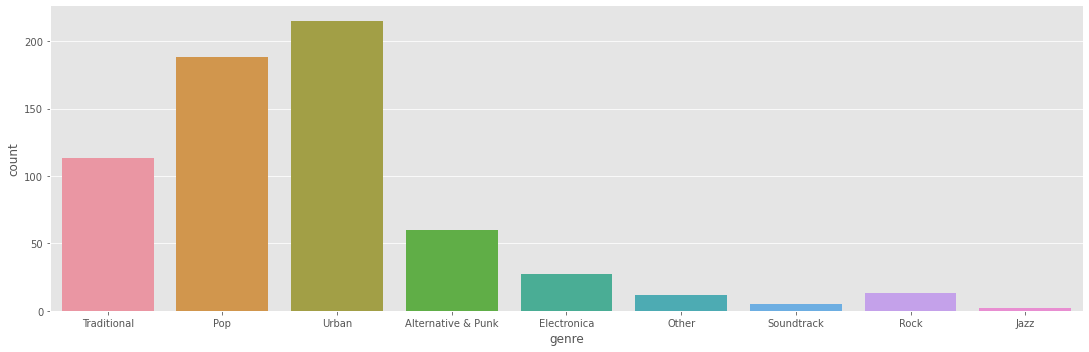

In [11]:
sb.factorplot('genre',data=artists_billboard,kind="count", aspect=3)

Entre los géneros musicales destacan Urban y Pop, seguidos de Tradicional.

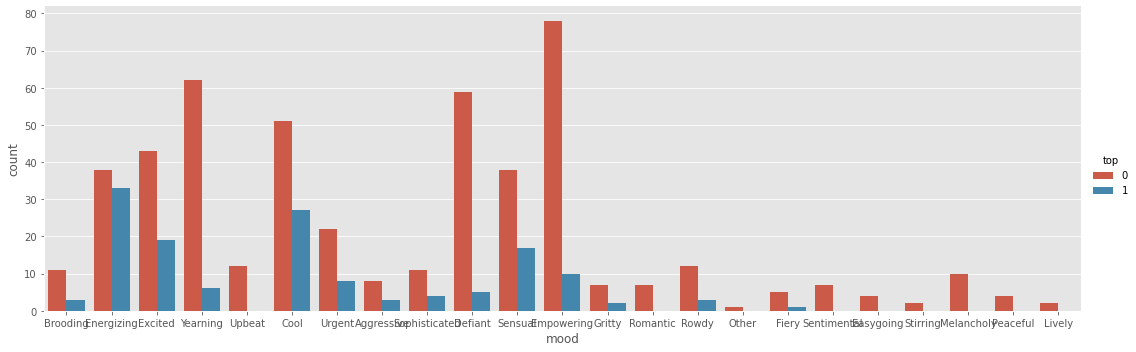

In [12]:
sb.factorplot('mood',data=artists_billboard,hue='top',kind="count", aspect=3)

### Visualizamos los años de nacimiento de los artistas

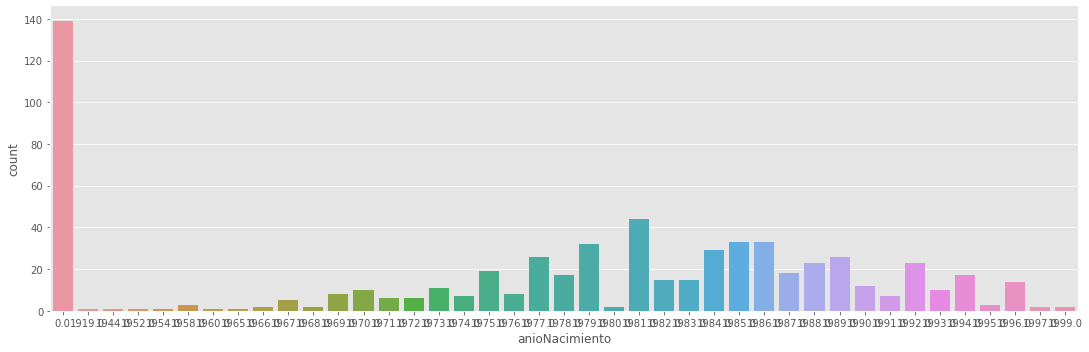

In [13]:
sb.factorplot('anioNacimiento',data=artists_billboard,kind="count", aspect=3)

In [14]:
#artists_billboard[['anioNacimiento', 'top']].groupby(['anioNacimiento'], as_index=False).agg(['mean', 'count', 'sum'])
nacimientosPorAnio = artists_billboard['anioNacimiento']
len(nacimientosPorAnio[nacimientosPorAnio<=0])

139

Notamos que tenemos 139 registros de canciones de las que desconocemos el año de nacimiento del artista. Deberemos tratar estos datos para poder utilizar el árbol.

# Comparemos los Top y los No-top

### Buscamos si hay alguna relación evidente entre Año y duración de Canción

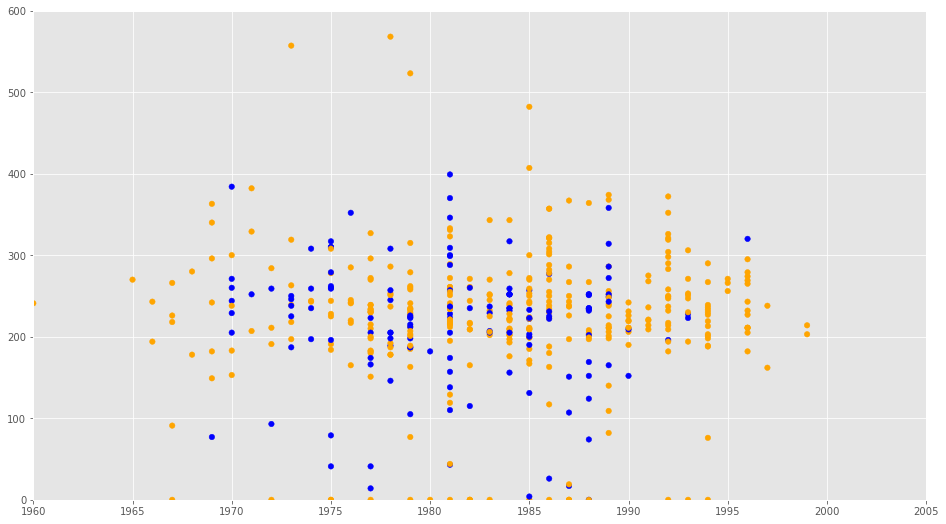

In [15]:
colores=['orange','blue']
tamanios=[60,40]

f1 = artists_billboard['anioNacimiento'].values
f2 = artists_billboard['durationSeg'].values

asignar=[]
for index, row in artists_billboard.iterrows():    
    asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([1960,2005,0,600])
plt.show()

No perece haber ningún patron a la vista, están bastante mezclados los top de los no-top.

## Arreglar las Edades de Artistas
Primero vamos a sustituir los ceros de la columna “anioNacimiento”por el valor None -que es es nulo en Python-.

In [21]:
def edad_fix(anio):
    if anio==0:
        return None
    return anio

artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

Luego vamos a calcular las edades en una nueva columna “edad_en_billboard” restando el año de aparición (los 4 primeros caracteres de chart_date) al año de nacimiento. En las filas que estaba el año en None, tendremos como resultado edad None.

In [22]:
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio

artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

In [23]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento,edad_en_billboard
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0,39.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0,25.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0,21.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0,25.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,NaN,NaN


### Calculamos promedio de edad y asignamos a los registros Nulos
Y finalmente asignaremos edades aleatorias a los registros faltantes: para ello, obtenemos el promedio de edad de nuestro conjunto (avg) y su desvío estándar (std) -por eso necesitábamos las edades en None- y pedimos valores random a la función que van desde avg – std hasta avg + std. En nuestro caso son edades de entre 21 a 37 años.

In [24]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)

conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])

artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


### Visualizamos las edades que agregamos
Podemos visualizar los valores que agregamos (en color verde) en el siguiente gráfico:

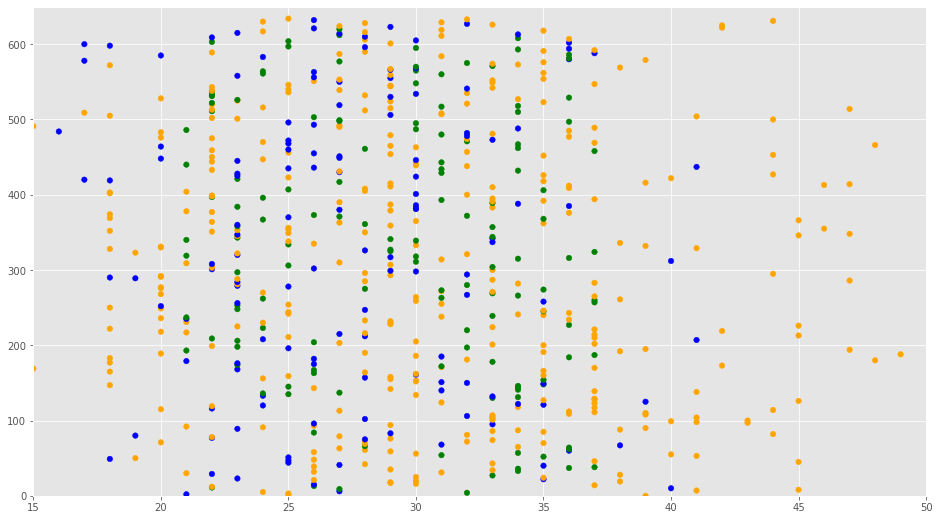

In [25]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index

colores = ['orange','blue','green']

asignar=[]
for index, row in artists_billboard.iterrows():    
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])

plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

# Mapeo de Atributos
Realizaremos un mapeo de los atributos de entrada para poder transformarlos a categorias que podamos utilzar en nuestro árbol de decisión.

Primero vamos a ver un resumen de los datos que tenemos:

In [26]:
separador = "### ### ###"
grouped11 = artists_billboard.groupby('mood').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)
print(separador)
print("Tempos de Canción: " + str(artists_billboard['tempo'].unique()))
print(separador)
print("Tipos de Artista: " + str(artists_billboard['artist_type'].unique()))
print(separador)
grouped11 = artists_billboard.groupby('genre').size()#.sum().reset_index()
neworder11 = grouped11.sort_values(ascending=False)
print(neworder11)

mood
Empowering       88
Cool             78
Energizing       71
Yearning         68
Defiant          64
Excited          62
Sensual          55
Urgent           30
Sophisticated    15
Rowdy            15
Brooding         14
Upbeat           12
Aggressive       11
Melancholy       10
Gritty            9
Romantic          7
Sentimental       7
Fiery             6
Peaceful          4
Easygoing         4
Lively            2
Stirring          2
Other             1
dtype: int64
### ### ###
Tempos de Canción: ['Medium Tempo' 'Slow Tempo' 'Fast Tempo']
### ### ###
Tipos de Artista: ['Male' 'Female' 'Mixed']
### ### ###
genre
Urban                 215
Pop                   188
Traditional           113
Alternative & Punk     60
Electronica            27
Rock                   13
Other                  12
Soundtrack              5
Jazz                    2
dtype: int64


Ahora vamos a transformar varios de los datos de entrada en valores categóricos. Las edades, las separamos en: menor de 21 años, entre 21 y 26, etc. las duraciones de canciones también, por ej. entre 150 y 180 segundos, etc. Para los estados de ánimo (mood) agrupé los que eran similares.

El Tempo que puede ser lento, medio o rápido queda mapeado: 0-Rapido, 1-Lento, 2-Medio (por cantidad de canciones en cada tempo: el Medio es el que más tiene)

In [27]:
# Mood Mapping 
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping 
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0} ).astype(int)
# Genre Mapping 
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)
# artist_type Mapping 
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)


# Mapping edad en la que llegaron al billboard
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4

# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded'] 					       = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

Finalmente obtenemos un nuevo conjunto de datos llamado artists_encoded con el que tenemos los atributos definitivos para crear nuestro árbol. Para ello, quitamos todas las columnas que no necesitamos con “drop”:

In [28]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

# Analizamos nuestros datos de Entrada Categóricos

In [29]:
artists_encoded.head()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
0,0,4,2,2,3,3.0,2.0
1,0,6,2,3,2,1.0,6.0
2,1,5,2,4,1,0.0,3.0
3,0,4,2,1,3,1.0,2.0
4,0,4,2,2,2,3.0,3.0


In [30]:
artists_encoded.describe()

,top,moodEncoded,tempoEncoded,genreEncoded,artist_typeEncoded,edadEncoded,durationEncoded
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.222047,4.344882,1.730709,2.755906,2.459843,2.051969,3.179528
std,0.415950,1.350003,0.603553,1.165463,0.740583,1.145066,1.775017
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000
50%,0.000000,4.000000,2.000000,3.000000,3.000000,2.000000,3.000000
75%,0.000000,5.500000,2.000000,4.000000,3.000000,3.000000,4.000000
max,1.000000,6.000000,2.000000,4.000000,3.000000,4.000000,6.000000


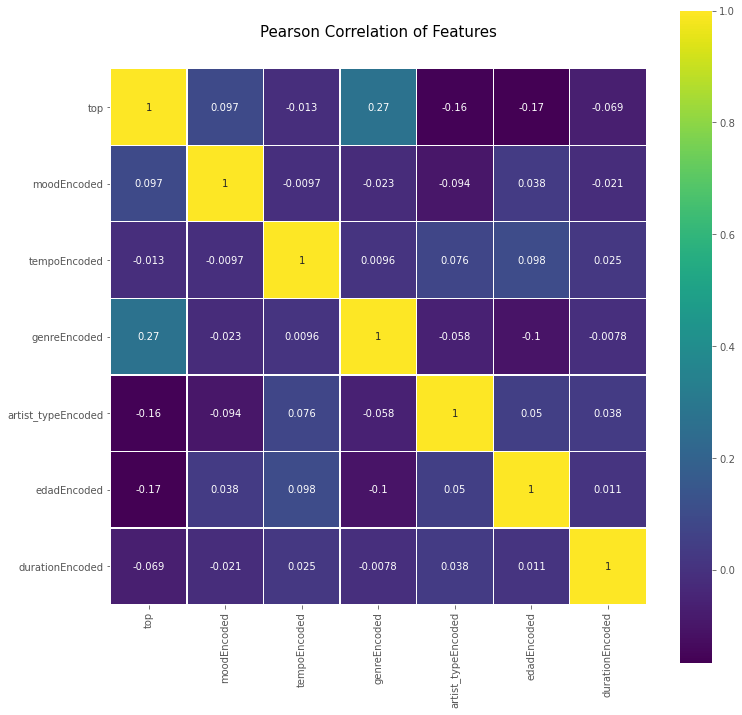

In [31]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sb.heatmap(artists_encoded.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## Como quedan los top en relación a los datos mapeados
Revisemos en tablas cómo se reparten los top=1 en los diversos atributos mapeados. Sobre la columna sum, estarán los top, pues al ser valor 0 o 1, sólo se sumarán los que sí llegaron al número 1.

In [32]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
moodEncoded                    
0            0.000000     1   0
1            0.000000     8   0
2            0.274194    62  17
3            0.145631   103  15
4            0.136986   146  20
5            0.294872   156  46
6            0.270440   159  43

Tabla anterior: La mayoría de top 1 los vemos en los estados de ánimo 5 y 6 con 46 y 43 canciones

In [33]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                        mean count sum
artist_typeEncoded                    
1                   0.305263    95  29
2                   0.320261   153  49
3                   0.162791   387  63

Tabla anterior: Aqui están bastante repartidos, pero hay mayoría en tipo 3: artistas masculinos

In [34]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                  mean count sum
genreEncoded                    
0             0.105263    19   2
1             0.070000   100   7
2             0.008850   113   1
3             0.319149   188  60
4             0.330233   215  71

Tabla anterior: Los géneros con mayoría son evidentemente los géneros 3 y 4 que corresponden con Urbano y Pop

In [35]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top           
                  mean count  sum
tempoEncoded                     
0             0.226415    53   12
1             0.246154    65   16
2             0.218569   517  113

Tabla anterior: El tempo con más canciones exitosas en el número 1 es el 2, tempo medio

In [36]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                     mean count sum
durationEncoded                    
0.0              0.295775    71  21
1.0              0.333333    30  10
2.0              0.212963   108  23
3.0              0.202381   168  34
4.0              0.232143   112  26
5.0              0.145455    55   8
6.0              0.208791    91  19

Tabla anterior: Están bastante repartidos en relación a la duración de las canciones

In [37]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

top          
                 mean count sum
edadEncoded                    
0.0          0.257576    66  17
1.0          0.316129   155  49
2.0          0.262411   141  37
3.0          0.159292   226  36
4.0          0.042553    47   2

Tabla anterior: Edad con mayoría es la tipo 1 que comprende de 21 a 25 años.

# Buscamos la profundidad para nuestro Arbol de Decisión
Ya casi tenemos nuestro árbol. Antes de crearlo, vamos a buscar cuántos niveles de profundidad le asignaremos. Para ello, aprovecharemos la función de KFold que nos ayudará a crear varios subgrupos con nuestros datos de entrada para validar y valorar los árboles con diversos niveles de profundidad. De entre ellos, escogeremos el de mejor resultado.

Para crear el árbol utilizamos de la librería de sklearn tree.DecisionTreeClasifier pues buscamos un árbol de clasificación (no de Regresión). Lo configuramos con los parámetros:

* __criterion=entropy__ ó podría ser gini, pero utilizamos entradas categóricas
* __min_samples_split=20__ se refiere a la cantidad mínima de muestras que debe tener un nodo para poder subdividir.
* __min_samples_leaf=5__ cantidad mínima que puede tener una hoja final. Si tuviera menos, no se formaría esa hoja y “subiría” un nivel, su antecesor.
* __class_weight={1:3.5}__ IMPORTANTíSIMO: con esto compensamos los desbalances que hubiera. En nuestro caso, como venía diciendo anteriormente, tenemos menos etiquetas de tipo top=1 (los artistas que llegaron al número 1 del ranking). Por lo tanto, le asignamos 3.5 de peso a la etiqueta 1 para compensar. El valor sale de dividir la cantidad de top=0 (son 494) con los top=1 (son 141).

NOTA: estos valores asignados a los parámetros fueron puestos luego de prueba y error (muchas veces visualizando el árbol, en el siguiente paso y retrocediendo a este).

In [38]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)

# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold] 
        f_valid = artists_encoded.loc[valid_fold] 

        model = tree_model.fit(X = f_train.drop(['top'], axis=1), 
                               y = f_train["top"]) 
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), 
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.556101
         2          0.556126
         3          0.565625
         4          0.663095
         5          0.625372
         6          0.644221
         7          0.658284


Podmeos ver que en 4 niveles de splits tenemos el score más alto, con aproximadamente un 66%.

Ahora ya sólo nos queda crear y visualizar nuestro árbol de 4 niveles de profundidad.

# Creamos el Arbol de Decisión

In [39]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values 

# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)

# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )

# Antiguamente se utilizaba export_graphviz para convertir el dot en una imagen pero ahora se ha complicado mucho.
# Se ha generado el fichero tree1.dot. Buscar un visualizador de árboles dot online y ver el contenido. 
# Ejemplo:http://www.webgraphviz.com/

En la gráfica vemos, un nodo raíz que hace una primer subdivisión por género y las salidas van a izquierda por True que sea menor a 2.5, es decir los géneros 0, 1 y 2 (eran los que menos top=1 tenían) y a derecha en False van los géneros 3 y 4 que eran Pop y Urban con gran cantidad de usuarios top Billboard.

En el segundo nivel vemos que la cantidad de muestras (samples) queda repartida en 232 y 403 respectivamente.

A medida que bajamos de nivel veremos que los valores de entropía se aproximan más a 1 cuando el nodo tiene más muestras top=1 (azul) y se acercan a 0 cuando hay mayoría de muestras Top=0 (naranja).

En los diversos niveles veremos divisiones por tipo de artista , edad, duración y mood. También vemos algunas hojas naranjas que finalizan antes de llegar al último nivel: esto es porque alcanzan un nivel de entropía cero, o porque quedan con una cantidad de muestras menor a nuestro mínimo permitido para hacer split (20).

## Precisión del árbol

In [40]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

64.88


Nos da un valor de 64.88%. Notamos en que casi todas las hojas finales del árbol tienen samples mezclados sobre todo en los de salida para clasificar los top=1. Esto hace que se reduzca el score.

# Predicción del árbol de decisión
Vamos a testear nuestro árbol con 2 artistas que entraron al billboard 100 en 2017: Camila Cabello que llegó al numero 1 con la Canción Havana y Imagine Dragons con su canción Believer que alcanzó un puesto 42 pero no llegó a la cima.

In [41]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (1,5,2,4,1,0,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [1]
Probabilidad de Acierto: 84.54%


Nos da que Havana llegará al top 1 con una probabilidad de más del 84%. Un resultado muy bueno.

In [42]:
#predecir artista Imagine Dragons 
# con su canción Believer llego al puesto 42 Billboard US en 2017

x_test = pd.DataFrame(columns=('top','moodEncoded', 'tempoEncoded', 'genreEncoded','artist_typeEncoded','edadEncoded','durationEncoded'))
x_test.loc[0] = (0,4,2,1,3,2,3)
y_pred = decision_tree.predict(x_test.drop(['top'], axis = 1))
print("Prediccion: " + str(y_pred))
y_proba = decision_tree.predict_proba(x_test.drop(['top'], axis = 1))
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred][0]* 100, 2))+"%")

Prediccion: [0]
Probabilidad de Acierto: 88.89%


Nos da que la canción de Imagine Dragons NO llegará con una certeza del 88%. Otro acierto para el modelo.